# Code test for the sampling in the 2D case

In [1]:
# Library for linear algebra
import numpy as np
from numpy import linalg
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Linrary for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

Functions that evaluates the potential, the force and if the particle is in the reactant, product or transition region.

In [2]:
# Parameters of the potentials
x0=1.0
a0=1.0/3.0
b0=5.0/3.0
u0=5.0
w0=1.0/5.0

@njit(fastmath=True)
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 3.0/5.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4)
    return U

@njit(fastmath=True)
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-((q[0] - x0)**2 + y2))
    e4 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -3.0/5.0*q[0]*e2 - (q[0]-x0)*e3 - (q[0]+x0)*e4)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -3.0/5.0*(q[1] - b0)*e2 - q[1]*e3 - q[1]*e4)-4.0*w0*(q[1] - a0)**3
    return np.array([fx, fy])

R = 0.6

#@njit(fastmath=True)
#def state(q, R=0.3): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
#    state = 0  # Transition state
#    tmp1 = q[0]**2 + 1.15**2 + q[1]**2
#    tmp2 = 2.0*1.15*q[0]
#    if tmp1 - tmp2 < R**2:
#        U = potential(q)
#        if U <-2.4:  # Product state
#            state = 1
#    if tmp1 + tmp2 < R**2:
#        U = potential(q)
#        if U <-2.4:  # Reactant state
#            state = -1
#    return state

@njit(fastmath=True)
def state(q): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp1 = q[0]**2 + 1.15**2 + q[1]**2
    tmp2 = 2.0*1.15*q[0]
    if tmp1 - tmp2 < R**2:
        # Product state
        state = 1
    if tmp1 + tmp2 < R**2:
        # Reactant state
        state = -1
    return state

Langevin integrator.

In [3]:
@njit(fastmath=True)
def LI(q0, dt = 0.01, KbT = 0.5, seed=None, isteps = 200000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q_trans = np.empty((isteps, 2), dtype=np.float64)
    # Initial conditions
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    # Index for the transition trajectory
    j = 0
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
        if state(q[i+1,:]) == 0:
            q_trans[j,:] = q[i+1,:]
            j+=1
            
    if j == 0:
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out, out
    
    else:
        return q, q_trans[:j,:]

Function to do 2D histogram.

In [4]:
def plot_prob_distr(trajectories, xedge, yedge, delta, ncontour):
    ## Density plot of how much time the system passes in a given point
    # Borders of the plot
    xedges = np.arange(xedge[0],xedge[1], delta).tolist()
    yedges = np.arange(yedge[0],yedge[1], delta).tolist()
    # Load the data
    x = trajectories[:,0]
    y = trajectories[:,1]
    # Create the histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
    H = H.T  # Let each row list bins with common y range.
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax = plt.gca()
    # colormap, colorbar, labels, ect.
    im.set_cmap('RdBu')
    # contour lines
    x = np.arange(xedge[0],xedge[1], 0.025)
    y = np.arange(yedge[0],yedge[1], 0.025)
    X, Y = np.meshgrid(x, y)
    # Identity matrix
    I = X*0+1
    # Probability of the 
    U1 = u0*(np.exp(-(X**2 + Y**2)) - 3.0/5.0*np.exp(-(X**2 + (Y - b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
    U2 = w0*(X**4 + (Y - a0*I)**4)
    Z = U1 + U2
    CS = plt.contour(X, Y, Z, ncontour, colors='k', linewidths = 0.8)
    # labels and title
    plt.title("Sampling transition region")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)
    plt.show()

In [5]:
## First guess of the committor function: q increases linearly along x
# The committor starts from the inner edges of the states
@njit(fastmath=True)
def qLin(q):
    if q[0] <= R-1.15:
        return 0
    elif q[0] >= 1.15-R:
        return 1
    else:
        return q[0]/(2.0*(1.15-R))+0.5

#Gradient of the first committor guess
@njit(fastmath=True)
def dqLin(q):
    if q[0] < R-1.15 or q[0] > 1.15-R:
        return 0.0, 0.0
    else:
        return 1.0/(2.0*(1.15-R)), 0.0
    
#Second guess of the committor function: q increases along a circle
@njit(fastmath=True)
def qCircle(q):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else: 
        return (theta - alpha)/(np.pi - alpha)

#Gradient of the second committor guess
@njit(fastmath=True)
def dqCircle(q):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]>0:
            return q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), -q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        else:
            return -q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        
        
@njit(fastmath=True)
def qCircleU(q):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] < 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)

@njit(fastmath=True)
def dqCircleU(q):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1] > 0.0:
            return q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), -q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        else:
            return 0.0, 0.0            
                
@njit(fastmath=True)
def qCircleD(q):
    if q[0] == 0 and q[1] == 0:
        return 0.5
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0
    elif theta > np.pi - alpha:
        return 1.0
    else:
        if q[1] > 0.0:
            return 0.0
        else:
            return (theta - alpha)/(np.pi - alpha)   
        
@njit(fastmath=True)
def dqCircleD(q):
    if q[0] == 0.0 and q[1] == 0.0:
        return 0.0, 0.0
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + q[1]**2))
    alpha = np.arccos(np.sqrt(1.0 - (R/1.15)**2))
    if theta <= alpha:
        return 0.0, 0.0
    elif theta > np.pi - alpha:
        return 0.0, 0.0
    else: 
        if q[1]< 0.0:
            return -q[1]/(q[0]**2 + q[1]**2)/(np.pi - alpha), q[0]/(q[0]**2 + q[1]**2)/(np.pi - alpha)
        else:
            return 0.0, 0.0
        
# Third guess function: euclidian distance between the two states
@njit(fastmath=True)
def qDist(q):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 1.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15-R)**2:
        return 0.0
    else:
        return 1.0-(np.sqrt((q[0] - 1.15)**2 + q[1]**2)-R)/(2.0*(1.15-R))
        
@njit(fastmath=True)        
def dqDist(q):
    if (q[0] + 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 <= R**2:
        return 0.0, 0.0
    elif (q[0] - 1.15)**2 + q[1]**2 >= (2.0*1.15+R)**2:
        return 0.0, 0.0
    else:
        return -(q[0] - 1.15)/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2)), -q[1]/(2.0*(1.15-R)*np.sqrt((q[0] - 1.15)**2 + q[1]**2))

In [6]:
#Other circunferance guesses
yI = -2.0
@njit(fastmath=True)
def qCircleUI(q):
    if q[0] == 0 and q[1] == yI:
        return 0.5
    m1 = (-1.15*yI+np.sqrt((1.15*yI)**2-(R**2-1.15**2)*(R**2-yI**2)))/(R**2-1.15**2)
    m2 = (1.15*yI-np.sqrt((1.15*yI)**2-(R**2-1.15**2)*(R**2-yI**2)))/(R**2-1.15**2)
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + (q[1]-yI)**2))
    alpha = np.arccos(-(1.15-m2*yI)/np.sqrt((1.15-m2*yI)**2+(m2*1.15-m2**2*yI)**2))
    if q[1] < m1*q[0]+yI:
        return 0.0
    elif q[1] < m2*q[0]+yI:
        return 1.0
    elif theta <= np.pi - alpha:
        return 0.0
    elif theta > alpha:
        return 1.0
    else:
        return (theta - np.pi + alpha)/(2.0*alpha - np.pi)
        

@njit(fastmath=True)
def dqCircleUI(q):
    if q[0] == 0 and q[1] == yI:
        return 0.0, 0.0
    m1 = (-1.15*yI+np.sqrt((1.15*yI)**2-(R**2-1.15**2)*(R**2-yI**2)))/(R**2-1.15**2)
    m2 = (1.15*yI-np.sqrt((1.15*yI)**2-(R**2-1.15**2)*(R**2-yI**2)))/(R**2-1.15**2)
    theta = np.arccos(-q[0]/np.sqrt(q[0]**2 + (q[1]-yI)**2))
    alpha = np.arccos(-(1.15-m2*yI)/np.sqrt((1.15-m2*yI)**2+(m2*1.15-m2**2*yI)**2))
    if theta <= alpha1/2.0:
        return 0.0, 0.0
    elif theta > np.pi - alpha1/2.0 - alpha2/2.0:
        return 0.0, 0.0
    else:
        if q[1] < m1*q[0]+yI or q[1] < m2*q[0]+yI:
            return 0.0, 0.0
        else:
            return (q[1]-yI)/(q[0]**2 + (q[1]-yI)**2), -q[0]/(q[0]**2 + (q[1]-yI)**2)

In [7]:
@njit(fastmath=True)
def ListGuess(n, q):
    if n == 0:
        return qLin(q)
    elif n == 1:
        return qCircleU(q)
    else:
        return qDist(q)
    
@njit(fastmath=True)
def ListdGuess(n, q):
    if n == 0:
        return dqLin(q)
    elif n == 1:
        return dqCircleU(q)
    else:
        return dqDist(q)

In [8]:
n = 3

In [9]:
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

In [10]:
def comm_plot(c):
    n = len(c)
    # Resolution of the plot
    dx, dy = 0.01, 0.01
    # generate 2 2d grids for the x & y bounds
    y, x = np.mgrid[slice(-1.5, 2.5 + dy, dy),slice(-2.0, 2.0 + dx, dx)]
    # Plot the committor
    G = np.copy(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            # Product state
            if (x[i,j] - 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = 1.1
            # Reactant state
            elif (x[i,j] + 1.15)**2 + y[i,j]**2 <= R**2:
                G[i,j] = -0.1
            else:
                G[i,j] = 0.0
                for k in range(n):
                    G[i,j] += c[k]*ListGuess(k, [x[i,j],y[i,j]])

    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    G = G[:-1, :-1]
    levels = MaxNLocator(nbins=200).tick_values(G.min(), G.max())
    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    cmap = plt.get_cmap('RdBu')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    # contours are *point* based plots, so convert our bound into point centers
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    cf = plt.contourf(x[:-1, :-1] + dx/2., y[:-1, :-1] + dy/2., G, levels=levels,cmap=cmap)
    plt.colorbar(cf)
    # Potential 
    # contour lines
    x = np.arange(-2.0,2.0, 0.025)
    y = np.arange(-1.5,2.5, 0.025)
    X, Y = np.meshgrid(x, y)
    # Identity matrix
    I = X*0+1
    # Probability of the 
    U1 = u0*(np.exp(-(X**2 + Y**2)) - 3.0/5.0*np.exp(-(X**2 + (Y - b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
    U2 = w0*(X**4 + (Y - a0*I)**4)
    Z = U1 + U2
    CS = plt.contour(X, Y, Z, 15, colors='k', linewidths = 0.8)
    # Title and labels
    plt.title('Committor with coefficients '+str(c))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.show()

First trial run.

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q0' of function 'LI'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-3-9c220bc934db>", line 2:
@njit(fastmath=True)
def LI(q0, dt = 0.01, KbT = 0.5, seed=None, isteps = 200000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


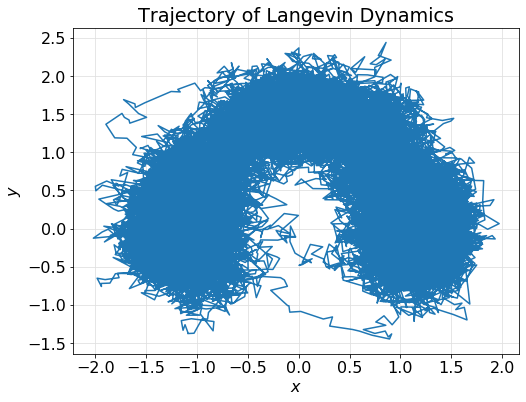

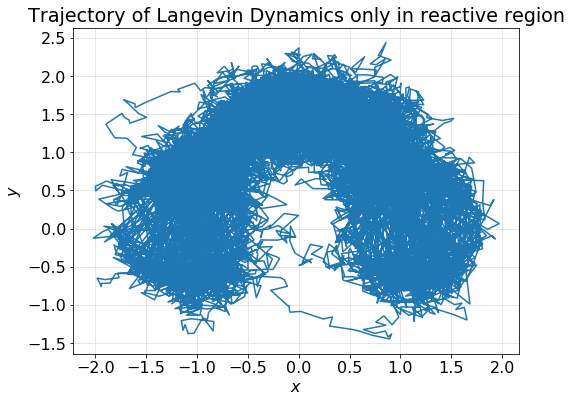

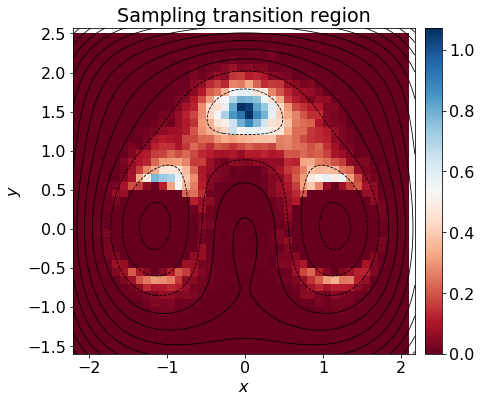

In [11]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.5
# Loop over many iterations with different initial conditions
q0 = [-1.15, 0.0]  # Initial conditions
traj, traj_trans = LI(q0, KbT = KBT, seed=42, isteps = 100000)  # I run the integrator

# Figure 1
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(traj[:,0], traj[:,1])
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Figure 2
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(traj_trans[:,0], traj_trans[:,1])
# Title,labels and grid
plt.title('Trajectory of Langevin Dynamics only in reactive region')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

### Probability density plot
plot_prob_distr(traj_trans, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

In [12]:
print(traj.shape)
print(traj_trans.shape)

(100000, 2)
(24145, 2)


In [13]:
print(n)

3


In [14]:
N = traj_trans.shape[0]
D = np.sqrt(2*KBT)
# Precompute the derivatives of the committors
y = np.zeros((N,2,n))
for i in range(N):
    for j in range(n):
        y[i,:,j] = ListdGuess(j, traj_trans[i,:])
        
M = np.zeros((n,n))
for i in range(n):
    for j in range(n): 
        for k in range(N):
            M[i,j] += y[k,0,i]*y[k,0,j]+y[k,1,i]*y[k,1,j]
M *= (D/N)
print('M')
print(M)

# Matrices used for the minimization procedure
A = [1.0 for i in range(n)]
B = [0.0 for i in range(n)]
# Minimization procedure
c = [1.0/n for i in range(n)]
cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
print('c', cout.x)

M
[[0.41707384 0.1197081  0.2600765 ]
 [0.1197081  0.07092433 0.13159385]
 [0.2600765  0.13159385 0.82305766]]
c [2.32471191e-04 9.99741124e-01 2.64051237e-05]


<ipython-input-7-9f37a71d5c6f>:4: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qLin'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-201292333a6b>", line 4:
@njit(fastmath=True)
def qLin(q):
^

  return qLin(q)
<ipython-input-7-9f37a71d5c6f>:6: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'qCircleU'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-201292333a6b>", line 53:
@njit(fastmath=True)
def qCircleU(q):
^

  return qCircleU(q)
<ipython-input-7-9f37a71d5c6f>:8: NumbaPendingDeprecationWarning: 
Encountered the use of a type th

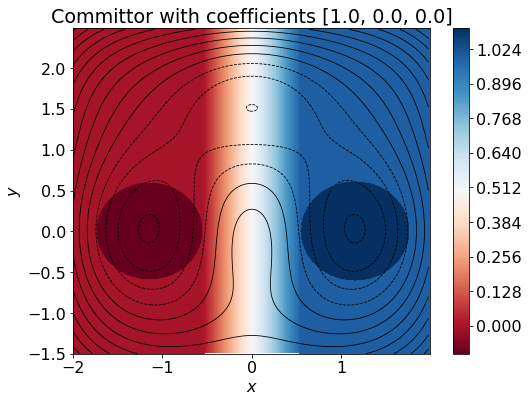

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-9-b46ac7370236>", line 2:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


I:= 0.4170738427783949


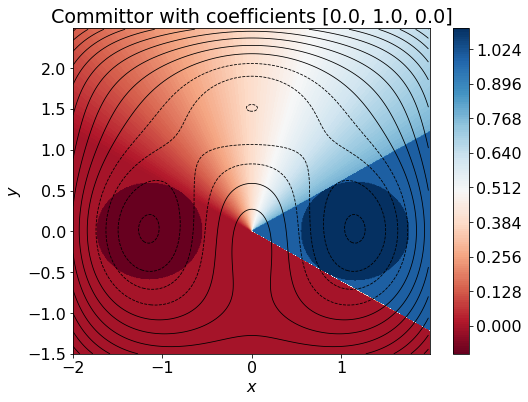

I:= 0.07092433397751018


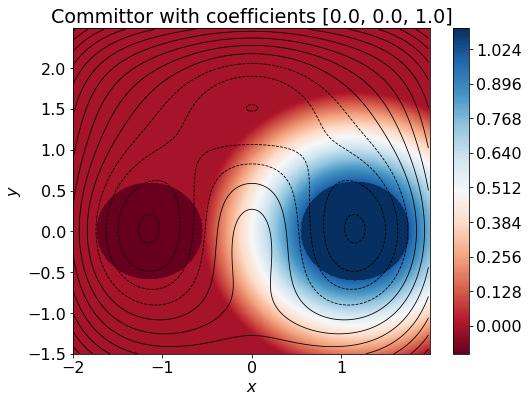

I:= 0.8230576629831453


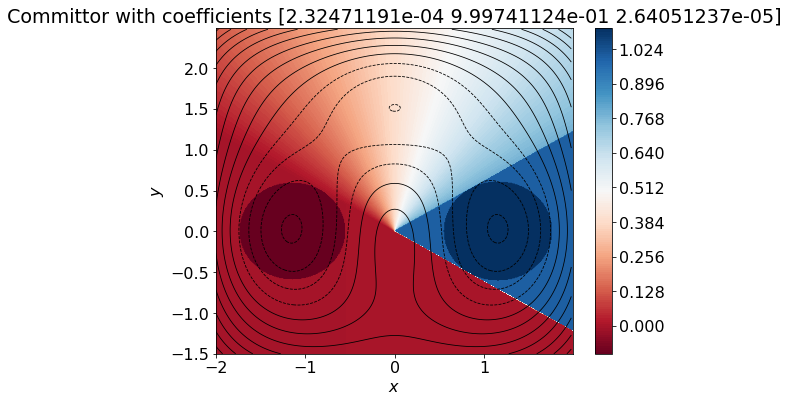

I:= 0.07095023444126079


In [15]:
comm_plot([1.0, 0.0, 0.0])
print("I:=",I([1.0, 0.0, 0.0],M))
comm_plot([0.0, 1.0, 0.0])
print("I:=",I([0.0, 1.0, 0.0],M))
comm_plot([0.0, 0.0, 1.0])
print("I:=",I([0.0, 0.0, 1.0],M))
comm_plot(cout.x)
print("I:=",I(cout.x,M))

In [16]:
@njit(fastmath=True)
def LI_VAR(q0, dt = 0.01, KbT = 0.5, seed=None, isteps = 200000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q_trans = np.empty((isteps, 2), dtype=np.float64)
    M = np.zeros((n,n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Initial position
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    # Index for the transition trajectory
    j = 0
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
        if state(q[i+1,:]) == 0:
            q_trans[j,:] = q[i+1,:]
            # Gradient components of the committors
            for k in range(n):
                dGx[k], dGy[k] = ListdGuess(k, q[i+1,:])  
            # Evaluating M Matrix
            for k in range(n):
                for l in range(n):
                    M[k,l] += dGx[k]*dGx[l]+dGy[k]*dGy[l]
            j+=1
    print(j)
    # Average M
    M /= (j-1)
    # Multiply for diffusion factor
    M *= np.sqrt(2.0*KbT)
    
    return M

In [17]:
## Runs of the Langevin dynamics
# Fix the temperature
KBT = 0.5
# Loop over many iterations with different initial conditions
q0 = [-1.15, 0.0]  # Initial conditions
M = LI_VAR(q0, KbT = KBT, seed=42, isteps = 200000)  # I run the integrator

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q0' of function 'LI_VAR'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-16-a3a697a4e804>", line 2:
@njit(fastmath=True)
def LI_VAR(q0, dt = 0.01, KbT = 0.5, seed=None, isteps = 200000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


49027


In [18]:
print("M",M)
# Matrices used for the minimization procedure
A = [1.0 for i in range(n)]
B = [0.0 for i in range(n)]
# Minimization procedure
c = [1.0/n for i in range(n)]
cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
print('c', cout.x)

M [[0.41049226 0.11827334 0.25677106]
 [0.11827334 0.07142821 0.13350866]
 [0.25677106 0.13350866 0.82297368]]
c [2.47043260e-04 9.99730028e-01 2.29286630e-05]


In [19]:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None, dt = 0.01, KbT = 0.5, kr = 300, seed=None, isteps = 8000):
    ## Number of committor functions given as input
    n = len(c)
    
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps, n, n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        # Evaluate z
        z = 0.0
        for k in range(n):
            z += c[k]*ListGuess(k, q[i,:])
        # Gradient components of the committors
        for k in range(n):
            dGx[k], dGy[k] = ListdGuess(k, q[i,:])  
        # Evaluating M Matrix
        for k in range(n):
            for l in range(n):
                M[i,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            ratchetx = 0.0
            ratchety = 0.0
            for k in range(n):
                ratchetx += c[k]*dGx[k]
                ratchety += c[k]*dGy[k]
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*ratchetx*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*ratchety*(zmax - z)*dt
        i += 1
        s = state(q[i,:])
    
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, n, n), dtype=np.float64)
        for k in range(n):
            for l in range(n):
                outM[i,k,l] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-19-08df998e600c>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None, dt = 0.01, KbT = 0.5, kr = 300, seed=None, isteps = 8000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


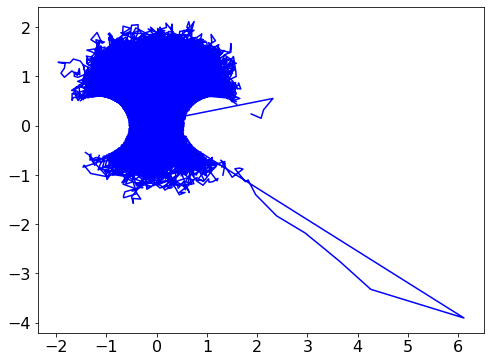

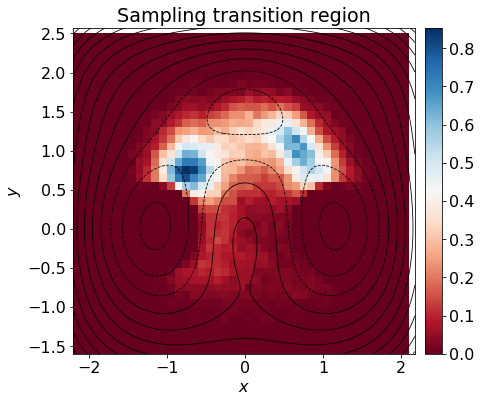

In [20]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
for j in range(1000):
    traj, M = LI_RMDN(c = [1.0/3.0, 1.0/3.0, 1.0/3.0], KbT = KBT)
    if traj[0,0] != 0.0 and traj[0,1] != 0.0:
        plt.plot(traj[:,0], traj[:,1], color='b')
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

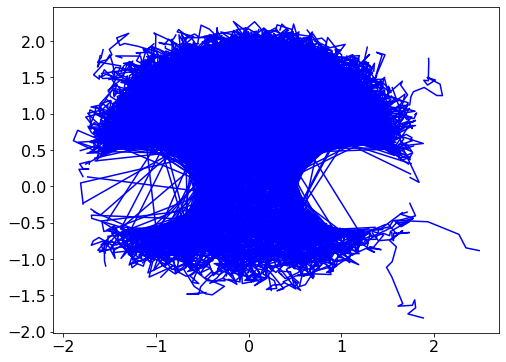

In [21]:
# Sampling of transition region
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
for j in range(1000):
    traj0, M = LI_RMDN(c = [1.0/n for i in range(n)], KbT = KBT)
    if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
        q0 = traj0[1::5,:]
        for i in range(q0.shape[0]):
            traj, traj_trans = LI(q0[i,:], KbT = KBT, isteps = 20)  # I run the integrator
            if traj_trans[0,0] != 0 and traj_trans[0,1] != 0:
                plt.plot(traj_trans[:,0], traj_trans[:,1], color='b')
                if tmp==0:
                    trajall = np.copy(traj_trans)
                    tmp = 1
                if tmp==1:
                    trajall = np.concatenate((trajall, traj_trans), axis=0)
plt.show()

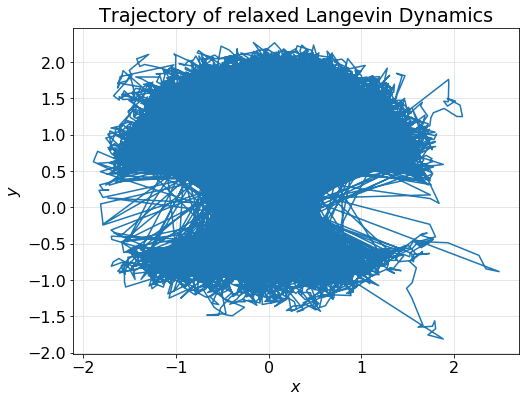

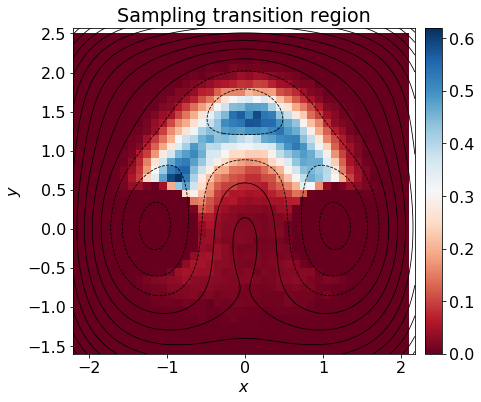

In [22]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(trajall[:,0], trajall[:,1])
# Title,labels and grid
plt.title('Trajectory of relaxed Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

In [23]:
@njit(fastmath=True)
def LIM(q0, dt = 0.01, KbT = 0.5, seed=None, isteps = 200000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q_trans = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps, n, n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Initial conditions
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    # Index for the transition trajectory
    j = 0
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
        if state(q[i+1,:]) == 0:
            # Gradient components of the committors
            for k in range(n):
                dGx[k], dGy[k] = ListdGuess(k, q[i+1,:])  
            # Evaluating M Matrix
            for k in range(n):
                for l in range(n):
                    M[j,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
            q_trans[j,:] = q[i+1,:]
            j+=1
            
    if j == 0:
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        Mout = np.empty((1, n, n), dtype=np.float64)
        Mout[0,0,0] = 0.0
        Mout[0,0,1] = 0.0
        Mout[0,1,0] = 0.0
        Mout[0,1,1] = 0.0
        return out, Mout
    
    else:
        return q_trans[:j,:], M[:j,:,:]

In [24]:
def Boltz_sample(c, dt = 0.01, KbT = 0.5, kr = 300, isteps = 8000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj0, M = LI_RMDN(c = c, dt=dt, KbT = KBT, kr=kr,isteps=isteps)
        if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
            q0 = traj0[1::5,:]
            for i in range(q0.shape[0]):
                traj, M = LIM(q0[i,:], KbT = KBT, isteps = 10)  # I run the integrator
                if traj[0,0] != 0 and traj[0,1] != 0:
                    if tmp==0:
                        Mall = np.copy(M)
                        tmp = 1
                    if tmp==1:
                        Mall = np.concatenate((Mall, M), axis=0)
                del traj, M
        del traj0
    
    D = np.sqrt(2.0*KBT)
    M = np.zeros((n,n), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]

    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    M *= D

    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
    # Minimization procedure
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
    
    return np.array(cout.x)

In [25]:
c = Boltz_sample(c = [1.0/n for i in range(n)], KbT = KBT)
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-19-08df998e600c>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None, dt = 0.01, KbT = 0.5, kr = 300, seed=None, isteps = 8000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[1.12452802e-01 8.87523704e-01 2.34945990e-05]


In [26]:
def Self_consistent(c,  dt = 0.01, KbT = 0.5, kr = 300, isteps = 8000, jsteps = 1000, ksteps = 5, alpha = 0.5):       
    n = len(c)
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [27]:
# Parameters of the run
KBT = 0.5
KR = 300
n = 3

Cycle =  1
Cycle =  2
Cycle =  3
Cycle =  4
Cycle =  5


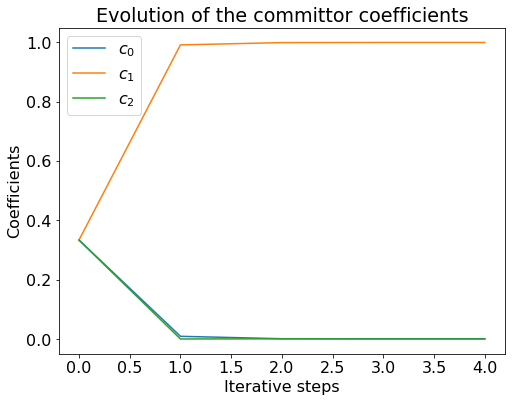

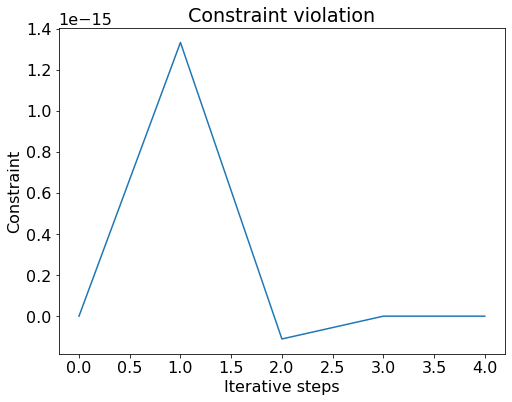

Final coefficients
[6.35256838e-04 9.99172340e-01 1.92403647e-04]


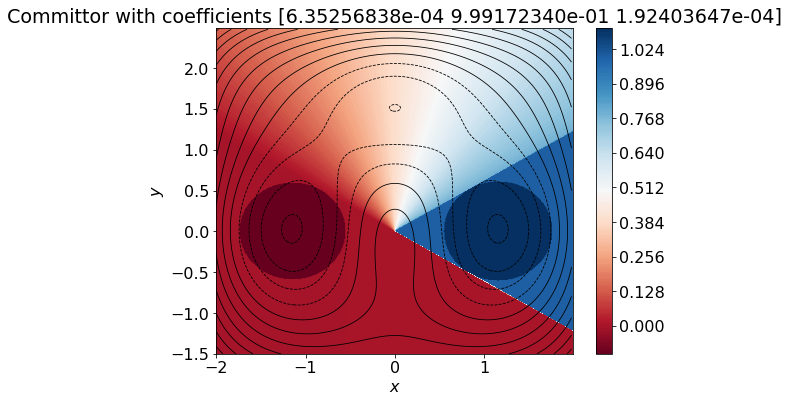

In [28]:
# Self consistent procedure
c = Self_consistent(c = [1.0/n for i in range(n)], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(c.shape[1]):
    plt.plot(c[:,i], label = r"$c_{}$".format(i))
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
constraint = np.zeros_like(c[:,0])
for i in range(c.shape[1]):
    constraint[i] = np.sum(c[i,:])-1.0
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
comm_plot(c = c[-1,:])

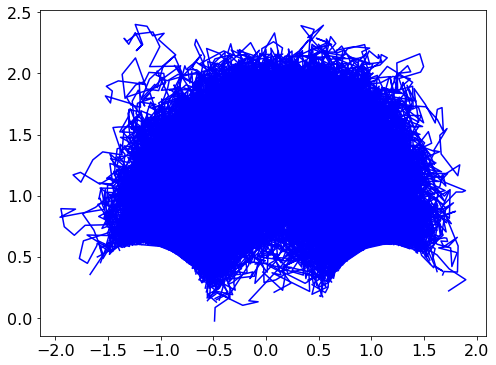

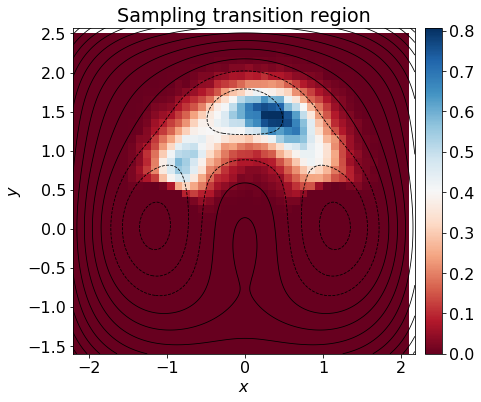

In [29]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
for j in range(1000):
    traj, M = LI_RMDN(c = c[-1,:], KbT = KBT)
    if traj[0,0] != 0.0 and traj[0,1] != 0.0:
        plt.plot(traj[:,0], traj[:,1], color='b')
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

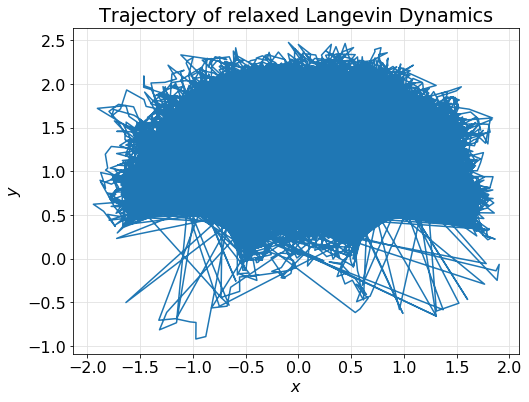

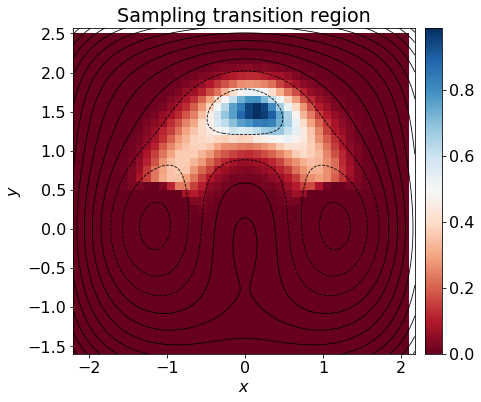

In [30]:
# Sampling of transition region
tmp = 0
for j in range(1000):
    traj0, M = LI_RMDN(c = c[-1,:], KbT = KBT)
    if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
        q0 = traj0[1::5,:]
        for i in range(q0.shape[0]):
            traj, traj_trans = LI(q0[i,:], KbT = KBT, isteps = 20)  # I run the integrator
            if traj_trans[0,0] != 0 and traj_trans[0,1] != 0:
                if tmp==0:
                    trajall = np.copy(traj_trans)
                    tmp = 1
                if tmp==1:
                    trajall = np.concatenate((trajall, traj_trans), axis=0)

plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(trajall[:,0], trajall[:,1])
# Title,labels and grid
plt.title('Trajectory of relaxed Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

## Without relaxation

In [31]:
@njit(fastmath=True)
def LI_RMDNR(c, q0 = None,  dt = 0.01, KbT = 0.15, kr = 150, isteps = 8000):
    ## Number of committor functions given as input
    n = len(c)
    
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps,n,n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        # Evaluate z
        z = 0.0
        for k in range(n):
            z += c[k]*ListGuess(k, q[i,:])
        # Gradient components of the committors
        for k in range(n):
            dGx[k], dGy[k] = ListdGuess(k, q[i,:])  
        # Evaluating M Matrix
        for k in range(n):
            for l in range(n):
                M[i,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            ratchetx = 0.0
            ratchety = 0.0
            for k in range(n):
                ratchetx += c[k]*dGx[k]
                ratchety += c[k]*dGy[k]
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*ratchetx*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*ratchety*(zmax - z)*dt
        i += 1
        s = state(q[i,:])
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, n, n), dtype=np.float64)
        for k in range(n):
            for l in range(n):
                outM[i,k,l] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

In [32]:
def Boltz_sample_R(c, dt = 0.01, KbT = 0.5, kr = 300, isteps = 8000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMDNR(c = c, dt=dt, KbT = KBT, kr=kr,isteps=isteps)
        if traj[0,0] != 0.0 and traj[0,1] != 0.0:
            if tmp==0:
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                Mall = np.concatenate((Mall, M), axis=0)
            del traj, M
    
    D = np.sqrt(2.0*KBT)
    M = np.zeros((n,n), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]

    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    M *= D

    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
    # Minimization procedure
    c = [1.0/n for i in range(n)]
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
    
    return np.array(cout.x)

In [33]:
def Boltz_sampleNR(c, dt = 0.01, KbT = 0.15, kr = 300, isteps = 8000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMDNR(c = c, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0,0] != 0 and traj[0,1] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    n = len(c)
    M = np.zeros((n,n), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
    # Minimization procedure
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint(A, 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds(B, A))
    
    
    return np.array(cout.x)


def Self_consistentNR(c ,  dt = 0.01, KbT = 0.15, kr = 300, isteps = 8000, jsteps = 1000, ksteps = 5, alpha = 0.5):       
    n = len(c)
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sampleNR(c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sampleNR(c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [34]:
# Parameters of the run
KBT = 0.5
KR = 300
n = 3

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDNR'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-31-283be59c854a>", line 2:
@njit(fastmath=True)
def LI_RMDNR(c, q0 = None,  dt = 0.01, KbT = 0.15, kr = 150, isteps = 8000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cycle =  3
Cycle =  4
Cycle =  5


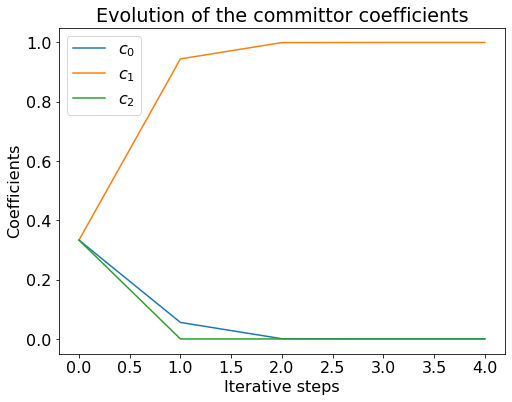

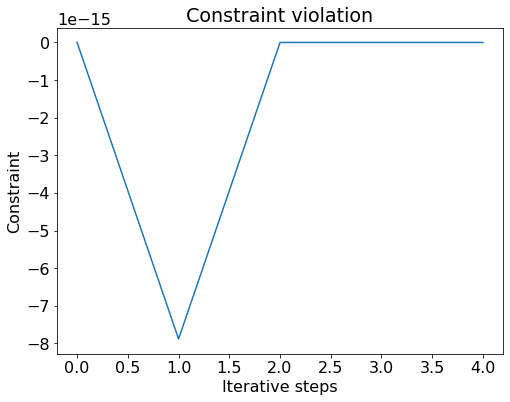

Final coefficients
[3.68825972e-04 9.99628227e-01 2.94701652e-06]


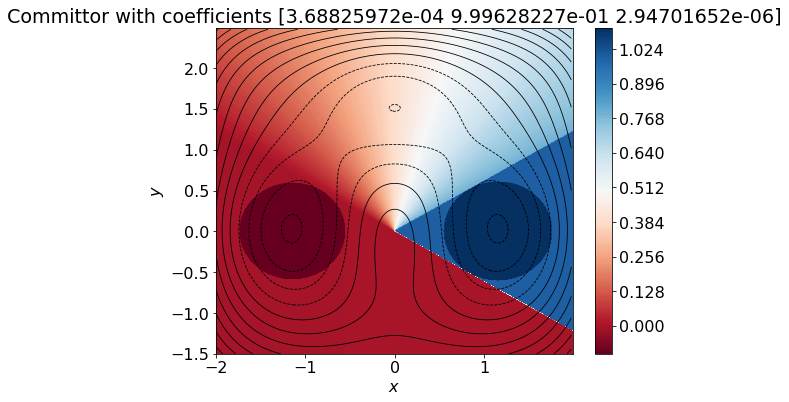

In [35]:
# Self consistent procedure
c = Self_consistentNR(c = [1.0/n for i in range(n)], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(c.shape[1]):
    plt.plot(c[:,i], label = r"$c_{}$".format(i))
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
constraint = np.zeros_like(c[:,0])
for i in range(c.shape[1]):
    constraint[i] = np.sum(c[i,:])-1.0
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
comm_plot(c = c[-1,:])

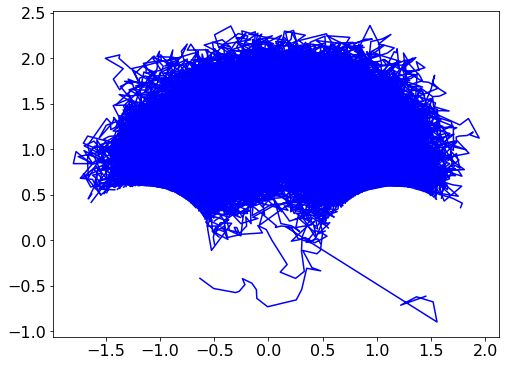

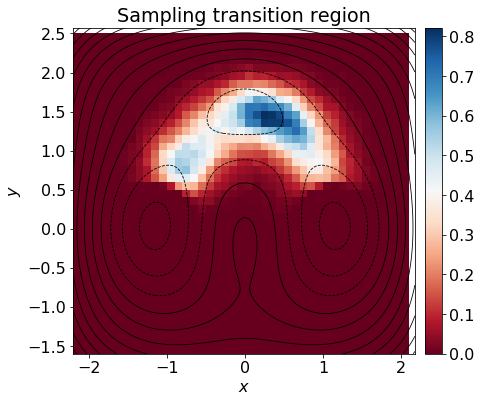

In [36]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
for j in range(1000):
    traj, M = LI_RMDN(c = c[-1,:], KbT = KBT)
    if traj[0,0] != 0.0 and traj[0,1] != 0.0:
        plt.plot(traj[:,0], traj[:,1], color='b')
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

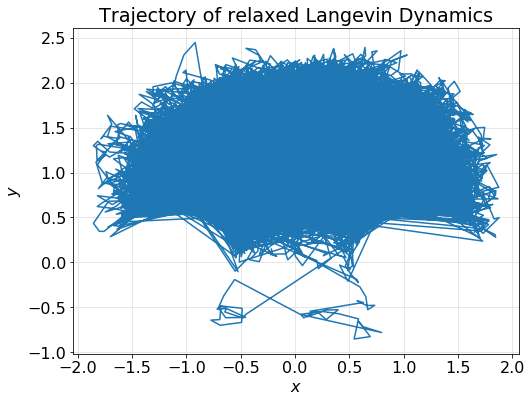

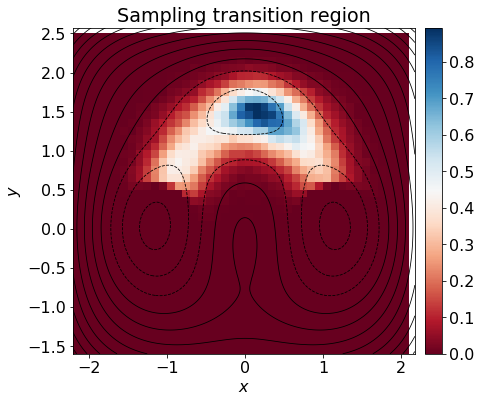

In [37]:
# Sampling of transition region
tmp = 0
for j in range(1000):
    traj0, M = LI_RMDN(c = c[-1,:], KbT = KBT)
    if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
        q0 = traj0[1::5,:]
        for i in range(q0.shape[0]):
            traj, traj_trans = LI(q0[i,:], KbT = KBT, isteps = 10)  # I run the integrator
            if traj_trans[0,0] != 0 and traj_trans[0,1] != 0:
                if tmp==0:
                    trajall = np.copy(traj_trans)
                    tmp = 1
                if tmp==1:
                    trajall = np.concatenate((trajall, traj_trans), axis=0)

plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(trajall[:,0], trajall[:,1])
# Title,labels and grid
plt.title('Trajectory of relaxed Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

## Just two guesses

In [52]:
@njit(fastmath=True)
def ListGuess(n, q):
    if n == 0:
        return qLin(q)
    else:
        return qDist(q)
    
@njit(fastmath=True)
def ListdGuess(n, q):
    if n == 0:
        return dqLin(q)
    else:
        return dqDist(q)

In [53]:
@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

In [54]:
@njit(fastmath=True)
def LI_VAR(q0, dt = 0.01, KbT = 0.5, seed=None, isteps = 200000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q_trans = np.empty((isteps, 2), dtype=np.float64)
    M = np.zeros((n,n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Initial position
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    # Index for the transition trajectory
    j = 0
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
        if state(q[i+1,:]) == 0:
            q_trans[j,:] = q[i+1,:]
            # Gradient components of the committors
            for k in range(n):
                dGx[k], dGy[k] = ListdGuess(k, q[i+1,:])  
            # Evaluating M Matrix
            for k in range(n):
                for l in range(n):
                    M[k,l] += dGx[k]*dGx[l]+dGy[k]*dGy[l]
            j+=1
    print(j)
    # Average M
    M /= (j-1)
    # Multiply for diffusion factor
    M *= np.sqrt(2.0*KbT)
    
    return M

@njit(fastmath=True)
def LI_RMDN(c, q0 = None, dt = 0.01, KbT = 0.5, kr = 300, seed=None, isteps = 8000):
    ## Number of committor functions given as input
    n = len(c)
    
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps, n, n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Assign initial position to the border of the reactant state
    if q0 is None:
        r = random.random_sample()
        q[0,0] = -1.15+R*r+0.001
        q[0,1] = R*np.sqrt(1.0-r**2)+0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        # Evaluate z
        z = 0.0
        for k in range(n):
            z += c[k]*ListGuess(k, q[i,:])
        # Gradient components of the committors
        for k in range(n):
            dGx[k], dGy[k] = ListdGuess(k, q[i,:])  
        # Evaluating M Matrix
        for k in range(n):
            for l in range(n):
                M[i,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
        # Dynamics
        if z > zmax:
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            ratchetx = 0.0
            ratchety = 0.0
            for k in range(n):
                ratchetx += c[k]*dGx[k]
                ratchety += c[k]*dGy[k]
            q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)+kr*ratchetx*(zmax - z)*dt
            q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)+kr*ratchety*(zmax - z)*dt
        i += 1
        s = state(q[i,:])
    
    M *= np.sqrt(2.0*KbT)
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outM = np.empty((1, n, n), dtype=np.float64)
        for k in range(n):
            for l in range(n):
                outM[i,k,l] = 0.0
        return out, outM
        
    return q[j+1:i-1,:], M[j+1:i-1,:,:]

@njit(fastmath=True)
def LIM(q0, dt = 0.01, KbT = 0.5, seed=None, isteps = 200000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q_trans = np.empty((isteps, 2), dtype=np.float64)
    M = np.empty((isteps, n, n), dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    dGy = np.empty(n, dtype=np.float64)
    # Initial conditions
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    # Index for the transition trajectory
    j = 0
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+D*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+D*np.random.normal(0,1)
        if state(q[i+1,:]) == 0:
            # Gradient components of the committors
            for k in range(n):
                dGx[k], dGy[k] = ListdGuess(k, q[i+1,:])  
            # Evaluating M Matrix
            for k in range(n):
                for l in range(n):
                    M[j,k,l] = dGx[k]*dGx[l]+dGy[k]*dGy[l]
            q_trans[j,:] = q[i+1,:]
            j+=1
            
    if j == 0:
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        Mout = np.empty((1, n, n), dtype=np.float64)
        Mout[0,0,0] = 0.0
        Mout[0,0,1] = 0.0
        Mout[0,1,0] = 0.0
        Mout[0,1,1] = 0.0
        return out, Mout
    
    else:
        return q_trans[:j,:], M[:j,:,:]

def Boltz_sample(c, dt = 0.01, KbT = 0.5, kr = 300, isteps = 8000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj0, M = LI_RMDN(c = c, dt=dt, KbT = KBT, kr=kr,isteps=isteps)
        if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
            q0 = traj0[1::5,:]
            for i in range(q0.shape[0]):
                traj, M = LIM(q0[i,:], KbT = KBT, isteps = 10)  # I run the integrator
                if traj[0,0] != 0 and traj[0,1] != 0:
                    if tmp==0:
                        Mall = np.copy(M)
                        tmp = 1
                    if tmp==1:
                        Mall = np.concatenate((Mall, M), axis=0)
                del traj, M
        del traj0
    
    D = np.sqrt(2.0*KBT)
    M = np.zeros((n,n), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]

    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    M *= D

    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
    # Minimization procedure
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,constraints=LinearConstraint(A, 1.0, 1.0),options={'verbose': 0}, bounds=Bounds(B, A))
    
    return np.array(cout.x)

def Self_consistent(c,  dt = 0.01, KbT = 0.5, kr = 300, isteps = 8000, jsteps = 1000, ksteps = 5, alpha = 0.5):       
    n = len(c)
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [55]:
# Parameters of the run
KBT = 0.5
KR = 300
n = 2

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-54-0dcb1be29018>", line 43:
@njit(fastmath=True)
def LI_RMDN(c, q0 = None, dt = 0.01, KbT = 0.5, kr = 300, seed=None, isteps = 8000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cycle =  3
Cycle =  4
Cycle =  5


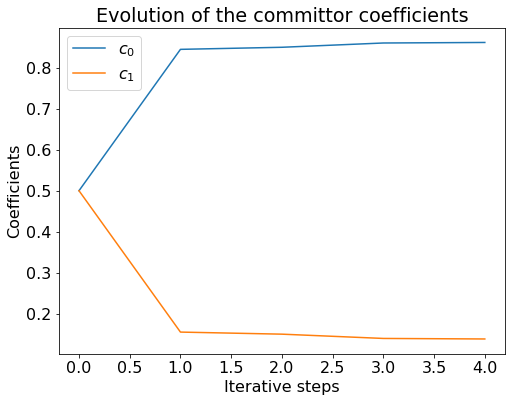

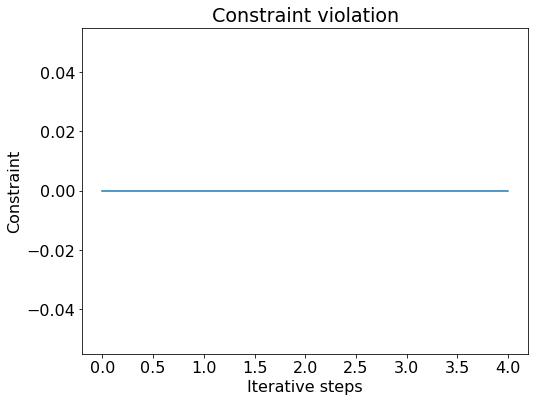

Final coefficients
[0.86139137 0.13860863]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q' of function 'ListGuess'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-52-4551092ea3de>", line 2:
@njit(fastmath=True)
def ListGuess(n, q):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


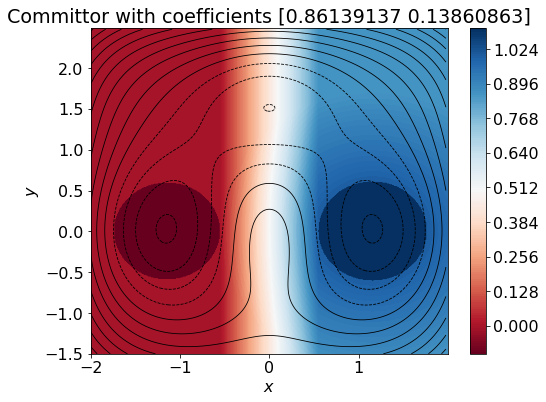

In [56]:
# Self consistent procedure
c = Self_consistent(c = [1.0/n for i in range(n)], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(c.shape[1]):
    plt.plot(c[:,i], label = r"$c_{}$".format(i))
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
constraint = np.zeros_like(c[:,0])
for i in range(c.shape[1]):
    constraint[i] = np.sum(c[i,:])-1.0
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
comm_plot(c = c[-1,:])

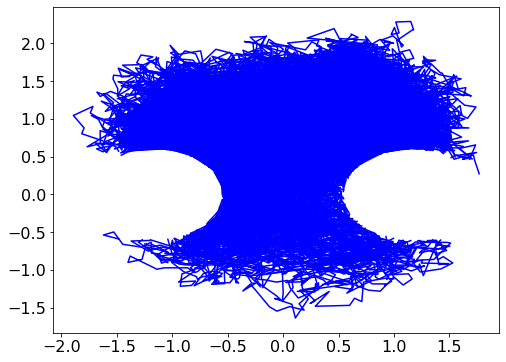

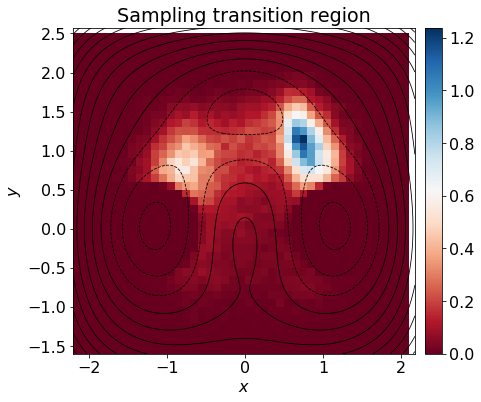

In [57]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
for j in range(1000):
    traj, M = LI_RMDN(c = c[-1,:], KbT = KBT)
    if traj[0,0] != 0.0 and traj[0,1] != 0.0:
        plt.plot(traj[:,0], traj[:,1], color='b')
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)

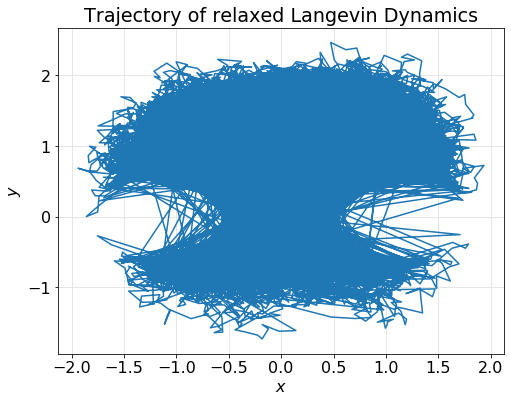

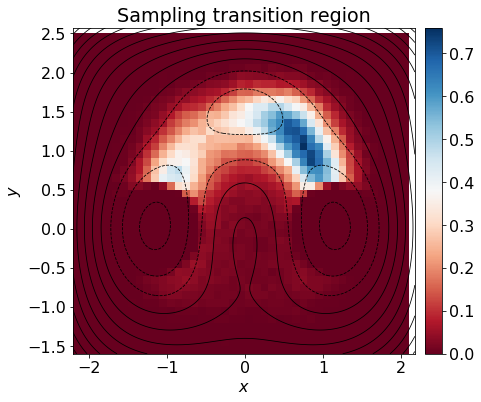

In [58]:
# Sampling of transition region
tmp = 0
for j in range(1000):
    traj0, M = LI_RMDN(c = c[-1,:], KbT = KBT)
    if traj0[0,0] != 0.0 and traj0[0,1] != 0.0:
        q0 = traj0[1::5,:]
        for i in range(q0.shape[0]):
            traj, traj_trans = LI(q0[i,:], KbT = KBT, isteps = 20)  # I run the integrator
            if traj_trans[0,0] != 0 and traj_trans[0,1] != 0:
                if tmp==0:
                    trajall = np.copy(traj_trans)
                    tmp = 1
                if tmp==1:
                    trajall = np.concatenate((trajall, traj_trans), axis=0)

plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(trajall[:,0], trajall[:,1])
# Title,labels and grid
plt.title('Trajectory of relaxed Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

### Probability density plot
plot_prob_distr(trajall, [-2.2, 2.2], [-1.6, 2.6], 0.1, 15)